# The Black-Scholes Model

## Black-Scholes-Merton PDE
Perhaps one of the most known relationships in finance is the Black-Scholes-Merton (BSM) equation. The BSM equation is a partial differential equation, which describes the price of an option over time. For a European stock option paying no dividends the equation is
$$ \frac{\partial V}{\partial t} +\frac{1}{2}\sigma^2 S^2 \frac{\partial V^2}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0, $$
where $V = V(S,t)$ is the price of the derivative as a function of time and stock price, $S$ is the price of the underlying stock, $\sigma$ is the volatility of return of the underlying asset and $r$ is the annualised risk-free interest rate, continuoulsy compounded.
The most interesting aspect of this eqution is that one should, in theory, be able to hedge an investment by buying and selling the underlying asset in just the right way and consequently eliminate all risk. This hedge, in turn, implies that there must be only one right price for the option. In the Black-Scholes world, severel assumptions are made.
* There exists a risk free assets in which any investor can invest at the risk free interest rate $r$.
* The instantaneous logarithmic return of a stock price is an infinitesimal random walk with drift; more precisely, the stock follows a geometric Brownian motion. Drift and volatility is constant.
* The stock does noe pay a dividend.
* There is no arbitrage oppourtunites, ie. there is no way to make a riskless profit.
* It is possible to borrow and lend any amount, even fractional, of cash at the riskless rate.
* it is possible to buy and sell any amount, even fractional, of the stock, including selling short.
* The transactions do not incur any fees or costs, ie. the market is frictionless.

## Monte Carlo Approach
Instead of trying to price an option by solving the equation above, we will take a numerical approach. As already stated, the underlying stock of the model follows a geometric Brownian motion described by the following stochastic differential equation (SDE)
$$ dS_t = r S_tdt + \sigma S_t dZ_t.$$
The only new variable here is $Z_t$ which is a (normal) Brownian motion, sometimes called a Wiener process. Notice that the notation has changed somewhat, because we have moved from a continuous to discrete variables. This means that time moves a chunk at atime, like a day, instead of continuously. 

### The Wiener process

A Wiener process $W_t$ is characterised by the following properties.
1. $W_0 = 0$
2. $W$ has independent increments: for every $t>0$, the future increments $W_{t+u}-W_t, u \geq0$, are independent of past values $W_s, s \leq t$.
3. $W_t$ has Gaussian increments: $W_{t+u} - W_t$ is normally distributed with mean $O$ and variance $u$, s.t. $W_{t+u} - W_t \sim \mathcal{N}(0,u)$

Below is a very simple implementation of a Wiener process in Python with a resulting plot that might as well have been a stock.

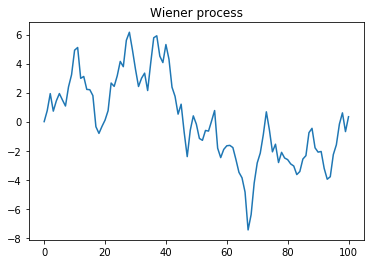

In [44]:
from matplotlib import pyplot as plt
import random

T = 100
u = 1
W_t = [0]

for i in range(T):
    W_last = W_t[-1]
    W_t.append(W_last + random.gauss(0, u))

plt.plot(W_t)
plt.title("Wiener process")
plt.show()

### Algorithm for Pricing a European Call Option
The value of an underlying stock $S$ at maturity time $T$ is
$$ S_T = S_{t-\Delta t} e^{(r - \frac{\sigma^2}{2})\Delta T + \sigma\sqrt{\Delta t}z_t}, $$
where $z$ is is a standard normally distrubuted stochastic variable. This relation is found by Euler discretisation of the SDE above. The keen student of finance may notice that it contains the formula for conintuously compounded interest, $S = S_0e^{rT}$, and some extra stochastic stuff.

The algorthm (recipe) we want to follow is
1. Divide the time interval $[0,T]$ in equidistant subintervals of length $t$.
2. Start iterating $i = 1,2,\dots,N$.

    1. For every time step $t \in {t, 2t, \dots, T}$ draw (pseudo) random numbers $z_t(i)$.
    2. Determine the time $T$ value of the stock $S_T(i)$ by applying the random number time step by time step.
    3. Determine the inner value $h_T$ of the European call option at $T$: $h_t(S_T(i)) = \max(S_T(i) - K, 0)$, where $K$ is the strike price of the option.
    
3. Sum up inner values, average, and discount them back with the riskless interest rate:
$$ C_0 \approx e^{-rT} \frac{1}{N} \sum_{i=1}^N h_T(S_T(i)).$$
This last equation is our Monte Carlo estimator for the European call option.

### Implementation of the Algorithm in Pure Python

In [41]:
from math import exp, sqrt, log
import time

# Parameters
S0 = 100.0  # Initial value
K = 105.0   # Strike price
T = 1.0     # Maturity
r = 0.05    # Riskless interest rate
sigma = 0.2 # Volatility
M = 50      # Number of time steps
dt = T / M  # Length of time interval
N = 500000  # Number of paths
S = []      # Empty list for stock price

# Timer start
start = time.time()

# Simulating N paths with M time steps
for i in range(N):
    path = []
    for t in range(M + 1):
        if t == 0:
            path.append(S0)
        else:
            z = random.gauss(0.0, 1.0)
            St = path[t - 1] * exp(( r - 0.5 * sigma**2)*dt\
                 + sigma*sqrt(dt)*z)
            path.append(St)
    S.append(path)

# Calculating Monte Carlo estimator - list comprehension
C0 = exp(-r*T)*sum([max(path[-1] - K, 0) for path in S]) / N

# Timer stop
time_elapsed = time.time() - start

# Results output
print("Price of European Call: {:>7f}" .format(C0))
print("Time elapsed: {:>7f}" . format(time_elapsed))

Price of European Call: 8.010399
Time elapsed: 35.646619


We now have our call option price, which is very good. What is not so good is that it took a while until the program finished. This is because we made use of iterative loops and Python's built in list data structure. This is generally an ineffective way to do things. Now we will do the same thing, but with vectorised variables using Numerical Python or NumPy.

### Improvements to the Algorithm Using NumPy

In [42]:
import numpy as np

# Timer start
start = time.time()

# Valuation algorithm
z = np.random.standard_normal((M + 1, N))
S = S0 * np.exp(np.cumsum((r - 0.5*sigma**2)*dt\
                        + sigma*sqrt(dt)*z, axis=0))

# Calculating Monte Carlo estimator
C0 = exp(-r*T)*sum(np.maximum(S[-1] - K, 0)) / N

# Timer stop
time_elapsed = time.time() - start

# Results output
print("Price of European Call: {:>7f}" .format(C0))
print("Time elapsed: {:>7f}" . format(time_elapsed))

Price of European Call: 8.154579
Time elapsed: 2.305499
